In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# 12ch

この章の目的は「TensorFlowの深くまで踏み込む」で\
「深くまで」というのは、より仕組み側の部分を指す\
深い場所のTensorFlowのを知ることで柔軟なカスタマイズができるようになろうということ\
\
具体的には独自の損失関数、指標、レイヤ、モデル、初期化子、正則化器、重みの制約などを実装するときに\
低水準の制御機能が必要となったときに役に立つ内容\
\
とは言ってもTensorFlowのユースケースの95％がtf.Kerasで対応可能\
→どんな問題でも用意されたもので十分な精度が出る優秀なライブラリということ\

# 12.1 TensorFlow弾丸旅行

→深く入り込む前にTetsorFlowについて確認しておこう

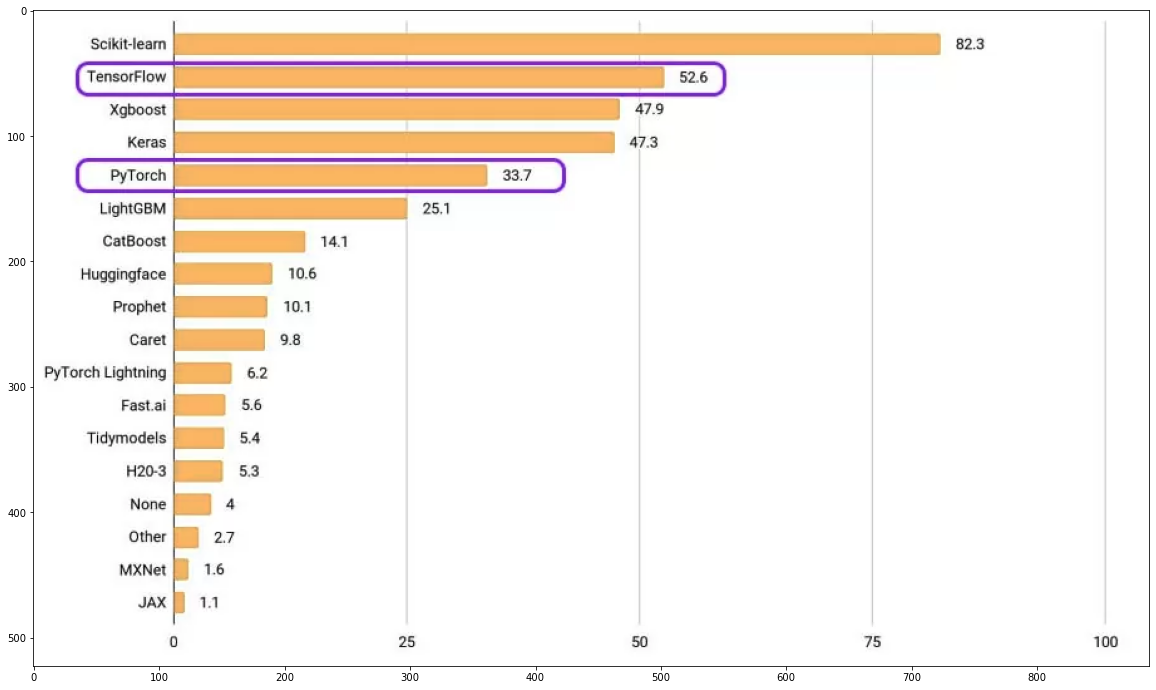

In [37]:
import cv2
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 20))
img = cv2.imread('DeepLearningライブラリ比較.webp')
plt.imshow(img)
plt.show()
%matplotlib inline

### TensorFlowの特徴
- GPUサポートがある
- 分散コンピューティングをサポート
\
\
TensorFlowは単一デバイスでの実行の他、GPUなどを用いた複数デバイスでの処理が考慮された設計になっている\
各デバイスへの処理やデバイス間通信はコストなどを計算して自動的に割り当てられるが、手動で指定することも可能\

- 計算速度やメモリの使用効率を最適化するための一種のJITコンパイラを内蔵(計算グラフであれば未使用ノードを切り落とすなどの最適化による効率化)
- 計算グラフはポータブルな形式にエクスポートできる
- 自動微分が実装しており、RMSPropやNadamなどの優れたオプティマイザを提供しているのであらゆるタイプの損失関数を最小化できる

これらのコア機能の上にたくさんの機能が構築されている→API(図12−1)\
※この図12−1以外にも多くのAPIが存在するので、公式ドキュメントで確認することをおすすめされている\
https://www.tensorflow.org/api_docs/python/tf/all_symbols

### 図12−1のAPIやその他
- TensorFlow Liteという形でiOSやAndroidでも実行可能
- TensorBoardによる可視化(10章参照)
- TensorFlowExtendedプロジェクトの大量生産のために作ったライブラリセット\
https://www.tensorflow.org/tfx?hl=ja\
→機械学習パイプラインを構築するためのフレームワーク(より高水準なイメージ)
- TensorFlowHubは学習済みのニューラルネットワークを簡単にダウンロードでき再利用するための手段を提供
- TensorFlowモデルガーデンはさまざまなニューラルネットワークアーキテクチャーを入手できる\
https://github.com/tensorflow/models/tree/master/official\
- TensorFlowResourcesではTensorflowベースのその他のプロジェクトを見ることができる\
https://www.tensorflow.org/resources/models-datasets\
→何かするときに既存のコードが見つかることが多い

# 12.2 TensorFlowのNumpyのような使い方

具体的にTensorFlowの作りについて見ていく

NumPyによく似ているテンソルを中心として動いている\
このテンソルについて理解することが12章の目的であるTensorFlowを深くまで踏み込むことにつながる

# 12.2.1 テンソルとそのオペレーション

In [38]:
import tensorflow as tf

# 行列
tf.constant([[1., 2., 3.], [4., 5., 6.]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [39]:
# スカラー
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [40]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
# shapeやdtypeが使える
print(t.shape)
print(t.dtype)

(2, 3)
<dtype: 'float32'>


In [41]:
t[:, 1:]
# t[..., 1:] #同じ意味

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

numpyやtensorflowで　...　は省略みたいな意味

In [42]:
# 3次元配列の場合
dim3 = np.arange(10*10*3).reshape(10, 10, 3)
dim3

array([[[  0,   1,   2],
        [  3,   4,   5],
        [  6,   7,   8],
        [  9,  10,  11],
        [ 12,  13,  14],
        [ 15,  16,  17],
        [ 18,  19,  20],
        [ 21,  22,  23],
        [ 24,  25,  26],
        [ 27,  28,  29]],

       [[ 30,  31,  32],
        [ 33,  34,  35],
        [ 36,  37,  38],
        [ 39,  40,  41],
        [ 42,  43,  44],
        [ 45,  46,  47],
        [ 48,  49,  50],
        [ 51,  52,  53],
        [ 54,  55,  56],
        [ 57,  58,  59]],

       [[ 60,  61,  62],
        [ 63,  64,  65],
        [ 66,  67,  68],
        [ 69,  70,  71],
        [ 72,  73,  74],
        [ 75,  76,  77],
        [ 78,  79,  80],
        [ 81,  82,  83],
        [ 84,  85,  86],
        [ 87,  88,  89]],

       [[ 90,  91,  92],
        [ 93,  94,  95],
        [ 96,  97,  98],
        [ 99, 100, 101],
        [102, 103, 104],
        [105, 106, 107],
        [108, 109, 110],
        [111, 112, 113],
        [114, 115, 116],
        [117, 118, 

In [43]:
dim3[..., 2, 0]

array([  6,  36,  66,  96, 126, 156, 186, 216, 246, 276])

In [44]:
# newaxisはマナー
t[..., 1, tf.newaxis]
# t[..., 1, None] #同じ意味

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

newaxisについての説明\
https://note.com/mlai/n/n64ca144365ac

$$$$

$$$$

さまざまな演算

In [45]:
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [46]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [47]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [48]:
t @ tf.transpose(t)
# tf.matmul(t, tf.transpose(t)) #同じ意味で行列の掛け算

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

$$$$

TensorFlowの中のkerasにも低水準APIが用意されている

In [49]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

# 12.2.2 テンソルとNumPy

テンソルとNumPyは相性が良く、変換が容易だがdtypeに注意\
NumPyは64ビットの精度がデフォルトだが、テンソルは32ビット\
ニューラルネットワークには32ビットで十分な上、高速に実行できRAMの消費量も減る\
NumPyからテンソルを生成するときはdtypeを設定することを覚えておこう

In [50]:
a = np.array([2., 4., 5.])
b = tf.constant(a)
b

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [51]:
c = tf.constant(a, dtype=tf.float32)
c

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2., 4., 5.], dtype=float32)>

In [52]:
# NumPy型をそのまま計算に用いることもできる
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [53]:
c.numpy()
# np.array(b) #同じ意味

array([2., 4., 5.], dtype=float32)

# 12.2.3 型変換

型変換は性能を大きく下げるため、TensorFlowではあえて型変換を行わない仕組みになっている

In [54]:
# dtypeに注目
print(tf.constant(2.))
print(tf.constant(40))
print(tf.constant(40, dtype=tf.float64))

tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(40, shape=(), dtype=int32)
tf.Tensor(40.0, shape=(), dtype=float64)


In [55]:
# tf.constant(2.) + tf.constant(40) #error

In [56]:
# tf.constant(2.) + tf.constant(40, dtype=tf.float64) #error

In [57]:
# NumPyなら計算可能
np.array(2.) + np.array(40)

42.0

In [58]:
# どうしても型変換が必要な場合は...castで変換
tf.constant(2.) + tf.cast(tf.constant(40), tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

# 12.2.4 変数

ここまで見てきたのは具体的な数字だが、書き換えを行うために必要となるのがtf.Variableである(さまざまな変数を呼び出せる箱のようなイメージ)\
重みの更新などの際に活用

In [59]:
# Variableで箱を用意して数値を入れる
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [60]:
# 箱の中身を2倍する
v.assign(v * 2)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [61]:
# 改めてvを呼び出してみる
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [62]:
# 場所を指定して数値を書き換え
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,   4.,   6.],
       [  8.,  10., 200.]], dtype=float32)>

In [63]:
# constantで作成した場合はどうなるか
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
print(t)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)


In [64]:
# t[1, 2] = tf.constant([10.]) #error

# 12.2.5 その他のデータ構造

※12.2.5の上位互換が付録F(P769)となっているのでこちらを紹介する\
\
TensorFlowが通常の不動小数点や整数のテンソル以外にサポートしているデータ構造を見ていく
- 文字列
- 不調和テンソル
- 疎テンソル
- テンソル配列
- 集合
- キュー

### 文字列

特に自然言語処理に役に立つ文字列型を保持できる

In [65]:
import tensorflow as tf

tf.constant(b'hello world') #b''はバイト型(Pythonで使用する特殊な文字列オブジェクト)　

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

「b'〜'」はバイト型(Pythonで使用する特殊な文字列オブジェクト)\
数字にもintやfloatがあるように文字列にも色々あるということで進めていきます

b'〜'とする理由はTensorFlowが自動的にUTF-８にエンコードしてしまうので...

In [76]:
tf.constant('cafe')

<tf.Tensor: shape=(), dtype=string, numpy=b'cafe'>

コードポイントでの表現：Unicodeで規定されている文字1つ1つには、最大で21bits（16進数で5～6桁）の数値が割り振られている

In [77]:
tf.constant([ord(c) for c in 'cafe'])

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 101], dtype=int32)>

In [120]:
# uの定義がなかったので調べて見た
print(chr(99), chr(97), chr(102), chr(233))

c a f é


In [138]:
# 文字列の長さ
u = 'café'
b = tf.strings.length(u, unit='UTF8_CHAR')

In [139]:
# コードポイント変換可能
tf.strings.unicode_decode(u, 'UTF-8')

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

複数の文字列が含まれているテンソルも操作できる

In [140]:
# 文字列の長さ
p = tf.constant(['Cafe', 'Coffee', 'caffe', '??'])
tf.strings.length(p, unit='UTF8_CHAR')

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2], dtype=int32)>

In [145]:
r = tf.strings.unicode_decode(p, 'UTF-8') #UTF8?
r

<tf.RaggedTensor [[67, 97, 102, 101], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 101], [63, 63]]>

### 不調和テンソル

不調和テンソルはサイズの異なる配列のリストを表す特別な種類のテンソル\
→行列のように[[〜], [〜]]と表示されるが、中身が縦×横で表現できない(長さの異なる)ものを格納するテンソル\
\
１次元では不調和テンソルは作れないので通常のテンソルとなる\

In [147]:
r[1]

<tf.Tensor: shape=(6,), dtype=int32, numpy=array([ 67, 111, 102, 102, 101, 101], dtype=int32)>

不調和テンソルを作成、操作するためのraggedパッケージが用意されている\
不調和テンソルの連結操作をやってみる

In [149]:
r2 = tf.ragged.constant([[65, 66], [], [67]])
print(tf.concat([r, r2], axis=0))

<tf.RaggedTensor [[67, 97, 102, 101], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 101], [63, 63], [65, 66], [], [67]]>


In [150]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 101, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71],
 [99, 97, 102, 102, 101], [63, 63, 72, 73]]>


to_tensorにより全てのテンソルが同じ長さになるようにに0パディングできる

In [152]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[ 67,  97, 102, 101,   0,   0],
       [ 67, 111, 102, 102, 101, 101],
       [ 99,  97, 102, 102, 101,   0],
       [ 63,  63,   0,   0,   0,   0]], dtype=int32)>

### 疎テンソル

疎テンソルとはほとんどの要素が0のテンソル(sparse tensor)\
0でない要素の座標(インデックス)とその値、テンソルの形を指定してtf.SparseTensorを呼び出す

In [158]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]], values=[1., 2., 3.], dense_shape=[3, 4])
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [159]:
# この記述で通常のテンソルに変換できる
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

疎テンソルは通常のテンソル(密テンソル)ほどオペレーションが充実していない\
例えば乗算はできるが加算ができない

In [160]:
s * 3.14

In [162]:
# s + 42.0 #error

### テンソル配列

テンソルのリストを表す\
配列内の任意の位置テンソルを書いたり出したりできる\
一度呼び出すと配列からその要素が空になる

In [167]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))
tensor1 = array.read(1)
tensor1

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

モードについては12章参照ということなので次週以降に登場するっぽいのでスルー

stackメソッドで1つのテンソルにまとめられる

In [168]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

### 集合

TensorFlowでは数学でよく聞くあの集合もサポートしている\
数学的な表記では集合はよく{}で表されるがテンソルでは[[]]で表す\
不調和テンソルという形では集合の処理ができないので0などでパディングし形を揃える必要がある

In [171]:
a = tf.constant([[1, 5, 9]])
b = tf.constant([[5, 6, 9, 11]])
u = tf.sets.union(a, b)
u

In [172]:
tf.sparse.to_dense(u)

<tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[ 1,  5,  6,  9, 11]], dtype=int32)>

同時に複数のペアの和集合を計算することもできる

In [177]:
a = tf.constant([[1, 5, 9], [10, 0, 0]])
b = tf.constant([[5, 6, 9, 11], [13, 0, 0, 0]]) #本は0が一個多い
u = tf.sets.union(a, b)
tf.sparse.to_dense(u)

<tf.Tensor: shape=(2, 5), dtype=int32, numpy=
array([[ 1,  5,  6,  9, 11],
       [ 0, 10, 13,  0,  0]], dtype=int32)>

[1, 0]の0は要素としての0だが、[1, 3],[1, 4]の0は自動でパディングされた0である\
パディング値はややこしくならないよう、要素として取り得ない数字に設定すべき

ということで0以外でのパディングを設定

In [178]:
tf.sparse.to_dense(u, default_value=-1)

<tf.Tensor: shape=(2, 5), dtype=int32, numpy=
array([[ 1,  5,  6,  9, 11],
       [ 0, 10, 13, -1, -1]], dtype=int32)>

In [179]:
# 差集合
u = tf.sets.difference(a, b)
tf.sparse.to_dense(u)

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[ 1],
       [10]], dtype=int32)>

In [180]:
u = tf.sets.difference(b, a)
tf.sparse.to_dense(u)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 6, 11],
       [13,  0]], dtype=int32)>

In [182]:
# 積集合
u = tf.sets.intersection(a, b)
tf.sparse.to_dense(u)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 9],
       [0, 0]], dtype=int32)>

tf.sets.size()の入力はSparseTensorを想定していて\
疎テンソルの0以外の要素がどのように並んでるかを把握できる

In [217]:
# size
c = tf.SparseTensor(indices=[[0, 1], [0, 2], [0, 3]], values=[1, 2, 3], dense_shape=[3, 4])
d = tf.SparseTensor(indices=[[0, 1], [0, 3], [1, 3]], values=[1, 2, 3], dense_shape=[3, 4])
c_size = tf.sets.size(c)
d_size = tf.sets.size(d)

In [218]:
tf.sparse.to_dense(c)

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[0, 1, 2, 3],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32)>

In [219]:
c_size

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 0, 0], dtype=int32)>

In [220]:
tf.sparse.to_dense(d)

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[0, 1, 0, 2],
       [0, 0, 0, 3],
       [0, 0, 0, 0]], dtype=int32)>

In [221]:
d_size

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 1, 0], dtype=int32)>

### キュー

データレコードを追加し取り出すことができるデータ構造のことである\
tf.queueパッケージで複数タイプのキューを実装している\
しかし、他の手法でより使いやすいAPIが作られてキューは無用になってしまった

In [224]:
# FIFOキュー(先入れ先出し)
q = tf.queue.FIFOQueue(3, [tf.int32, tf.string], shapes=[(), ()])
q.enqueue([10, b'windy'])
q.enqueue([15, b'sunny'])
q.size()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [225]:
q.dequeue()

[<tf.Tensor: shape=(), dtype=int32, numpy=10>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'windy'>]

In [226]:
# 複数レコードの操作も可能
q.enqueue_many([[13, 16], [b'cloudy', b'rainy']])

In [227]:
q.dequeue_many(3)

[<tf.Tensor: shape=(3,), dtype=int32, numpy=array([15, 13, 16], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'sunny', b'cloudy', b'rainy'], dtype=object)>]

その他のキューについては紹介のみ
- PaddingFIFOQueue\
キューの操作についてはFIFOと同じだが、サイズが短いレコードは自動でパディングされレコードが同じ形になるようにデキューされる
- PriorityQueue\
優先順位に基づいてデキューする(優先順位は整数で指定するが順位の低いものからデキューされ、同じ場合はFIFOでデキュー)
- RnadomShuffleQueue\
レコードが無作為な順序でデキューされる